In [1]:
import numpy as np
import pandas as pd
import arch as arch
from pathlib import Path
import os
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
%matplotlib inline

In [2]:
def load_dataset(path, parse_dates=None, index_col=None):
    return pd.read_csv(path, parse_dates=parse_dates, index_col=index_col)

path = '/home/nnemati/forcasting_time_series/kaggle_chalenge/sale_forcasting_chalenge/data/raw/'

In [3]:
train_df = load_dataset(os.path.join(path, 'train.csv'), parse_dates=['date'], index_col='id')
test_df = load_dataset(os.path.join(path, 'test.csv'), parse_dates=['date'])
transactions_df = load_dataset(os.path.join(path, 'transactions.csv'))

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'], format= "%Y-%m-%d")

In [5]:
test_df['date'] = pd.to_datetime(test_df['date'], format= "%Y-%m-%d")

In [6]:
transactions_df['date'] = pd.to_datetime(transactions_df['date'], format= "%Y-%m-%d")

In [7]:
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [8]:
#print(train_df.columns)

In [9]:
#if 'id' in train_df.columns:
#    print(train_df['id'])
#else:
#    print("The 'id' column does not exist in the DataFrame.")

In [10]:
#train_df.reset_index(inplace=True)

In [11]:
train_df

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [12]:
#train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d")
#train_df = train_df.set_index(['date'])

In [13]:
split_date = pd.Timestamp('2017-08-01')

In [14]:
train = train_df[train_df['date'] < split_date]
test = train_df[train_df['date'] >= split_date]

In [15]:
train

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
2974153,2017-07-31,9,POULTRY,470.513,1
2974154,2017-07-31,9,PREPARED FOODS,61.940,0
2974155,2017-07-31,9,PRODUCE,1517.552,6


In [16]:
test

,date,store_nbr,family,sales,onpromotion
id,,,,,
2974158,2017-08-01,1,AUTOMOTIVE,5.000,0
2974159,2017-08-01,1,BABY CARE,0.000,0
2974160,2017-08-01,1,BEAUTY,4.000,0
2974161,2017-08-01,1,BEVERAGES,2627.000,26
2974162,2017-08-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148


In [17]:
features = ['store_nbr', 'family', 'onpromotion']
target = 'sales'

X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]

In [18]:
y_train

id
0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
2974153     470.513
2974154      61.940
2974155    1517.552
2974156      56.000
2974157      12.000
Name: sales, Length: 2974158, dtype: float64

In [19]:
test_df

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [20]:
X_train

,store_nbr,family,onpromotion
id,,,
0,1,AUTOMOTIVE,0
1,1,BABY CARE,0
2,1,BEAUTY,0
3,1,BEVERAGES,0
4,1,BOOKS,0
...,...,...,...
2974153,9,POULTRY,1
2974154,9,PREPARED FOODS,0
2974155,9,PRODUCE,6


In [21]:
categorical_features = ['family']

X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)


In [22]:
X_train_encoded

,store_nbr,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
id,,,,,,,,,,,,,,,,,,,,,
0,1,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,0,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974153,9,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2974154,9,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2974155,9,6,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [23]:
def rmsle(y_true, y_pred):
    terms_to_sum = (np.log1p(y_pred + 1) - np.log1p(y_true + 1)) ** 2
    rmsle = np.sqrt(np.mean(terms_to_sum))
    return rmsle

In [24]:
#model = LinearRegression()
model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
#model = CatBoostRegressor(iterations=1000, depth=16, learning_rate=0.001, random_state=42)

In [25]:
model.fit(X_train_encoded, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
y_train_pred = model.predict(X_train_encoded)

In [27]:
rmsle_value = rmsle(y_train, y_train_pred)
print(f"RMSLE on training set: {rmsle_value}")

RMSLE on training set: 1.669904314659018


/tmp/ipykernel_355654/2049491104.py:2: RuntimeWarning: invalid value encountered in log1p
  terms_to_sum = (np.log1p(y_pred + 1) - np.log1p(y_true + 1)) ** 2


In [28]:
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

In [29]:
X_test_encoded

,store_nbr,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
id,,,,,,,,,,,,,,,,,,,,,
2974158,1,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2974159,1,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2974160,1,0,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2974161,1,26,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2974162,1,0,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,9,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3000884,9,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3000885,9,148,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [30]:
# Ensure that both X_train and X_test have the same columns after one-hot encoding
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)

In [31]:
missing_cols

set()

In [32]:
predictions = model.predict(X_test_encoded)

In [33]:
Results = y_test.to_frame()
Results["Predicted sales"] = predictions

In [34]:
Results[:100]['sales']

id
2974158       5.000
2974159       0.000
2974160       4.000
2974161    2627.000
2974162       0.000
             ...   
2974253     113.772
2974254    2611.133
2974255      17.000
2974256       8.000
2974257      15.000
Name: sales, Length: 100, dtype: float64

array([<Axes: xlabel='id'>, <Axes: xlabel='id'>], dtype=object)

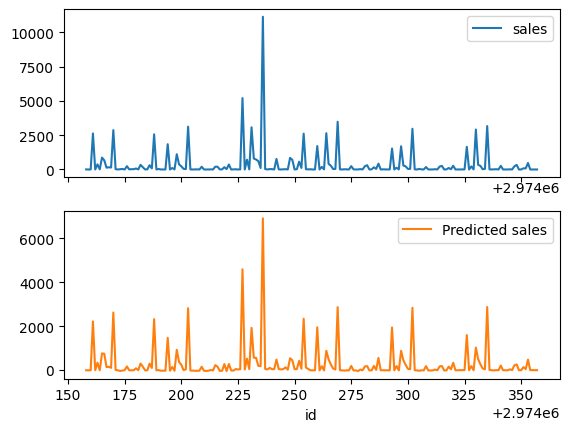

In [35]:
Results[:200].plot(subplots=True)

In [36]:
y_true = Results["sales"]
y_pred = Results["Predicted sales"]

epsilon = 1e-10  # A small offset to avoid negative values
y_true = np.maximum(epsilon, y_true)
y_pred = np.maximum(epsilon, y_pred)


msle = mean_squared_log_error(y_true, y_pred)


rmsle = np.sqrt(msle)

print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")


Root Mean Squared Logarithmic Error (RMSLE): 1.3217903007089165


In [37]:
Results["Predicted sales"]

id
2974158      -7.900459
2974159     -11.178219
2974160      -5.873891
2974161    2218.113770
2974162      -5.200322
              ...     
3000883     466.669678
3000884     140.518860
3000885    2398.784424
3000886     167.867386
3000887      42.891369
Name: Predicted sales, Length: 26730, dtype: float32

In [38]:
categorical_features = ['family']

test_df_encoded = pd.get_dummies(test_df, columns=categorical_features)

In [39]:
test_df_encoded

,id,date,store_nbr,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,3000888,2017-08-16,1,0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3000889,2017-08-16,1,0,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3000890,2017-08-16,1,2,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3000891,2017-08-16,1,20,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3000892,2017-08-16,1,0,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,1,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
28508,3029396,2017-08-31,9,0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
28509,3029397,2017-08-31,9,1,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28510,3029398,2017-08-31,9,9,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [40]:
print(test_df_encoded.columns)

Index(['id', 'date', 'store_nbr', 'onpromotion', 'family_AUTOMOTIVE',
       'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')


In [41]:
if 'id' in test_df_encoded.columns:
    test_df_encoded.drop('id', axis=1, inplace=True)

print(test_df_encoded.columns)

Index(['date', 'store_nbr', 'onpromotion', 'family_AUTOMOTIVE',
       'family_BABY CARE', 'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')


In [42]:
test_df_encoded

,date,store_nbr,onpromotion,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,...,family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD
0,2017-08-16,1,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2017-08-16,1,0,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2017-08-16,1,2,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2017-08-16,1,20,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2017-08-16,1,0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,1,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
28508,2017-08-31,9,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
28509,2017-08-31,9,1,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
28510,2017-08-31,9,9,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [43]:
test_df_encoded.drop('date', axis=1, inplace=True)

In [44]:
print(test_df_encoded.columns)

Index(['store_nbr', 'onpromotion', 'family_AUTOMOTIVE', 'family_BABY CARE',
       'family_BEAUTY', 'family_BEVERAGES', 'family_BOOKS',
       'family_BREAD/BAKERY', 'family_CELEBRATION', 'family_CLEANING',
       'family_DAIRY', 'family_DELI', 'family_EGGS', 'family_FROZEN FOODS',
       'family_GROCERY I', 'family_GROCERY II', 'family_HARDWARE',
       'family_HOME AND KITCHEN I', 'family_HOME AND KITCHEN II',
       'family_HOME APPLIANCES', 'family_HOME CARE', 'family_LADIESWEAR',
       'family_LAWN AND GARDEN', 'family_LINGERIE', 'family_LIQUOR,WINE,BEER',
       'family_MAGAZINES', 'family_MEATS', 'family_PERSONAL CARE',
       'family_PET SUPPLIES', 'family_PLAYERS AND ELECTRONICS',
       'family_POULTRY', 'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD'],
      dtype='object')


In [45]:
predictions = model.predict(test_df_encoded)

In [46]:
submission_sample = pd.read_csv('/home/nnemati/forcasting_time_series/kaggle_chalenge/sale_forcasting_chalenge/data/raw/sample_submission.csv')

In [47]:
submission_sample['sales'] = predictions

In [48]:
submission_sample.to_csv('/home/nnemati/forcasting_time_series/kaggle_chalenge/sale_forcasting_chalenge/data/raw/sample_submission.csv', index=False)

In [49]:
submission_sample

,id,sales
0,3000888,-7.900459
1,3000889,-11.178219
2,3000890,16.666872
3,3000891,2139.077148
4,3000892,-5.200322
...,...,...
28507,3029395,503.663147
28508,3029396,79.377518
28509,3029397,1320.835693
28510,3029398,167.867386
